# Wavenumber spectral fitting of pk2015 surface velocity and vorticity data


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from scipy import signal

import matplotlib.pyplot as plt
import numpy as onp

from jax import numpy as np
from jax import random as jrandom
import jax.scipy.linalg as jla
import optax

# Local functions
import nonstat_itides_jax as nsjax

In [2]:
def load_scenario(scenario):
    ncfiles = {'wp50':
             [
             '../DATA/ROMS/wp5/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp5/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010220-00010410.nc'
             ],
               'wp60':
             [
             '../DATA/ROMS/wp6/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp6/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp6/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp6/t2/inst_00010220-00010410.nc',
             ],
               'wp75':
             [
             '../DATA/ROMS/wp75/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp75/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp75/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp75/t2/inst_00010220-00010410.nc',
             ],
                'wp80':
             [
             '../DATA/ROMS/wp8/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp8/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010220-00010410.nc'
             ],
               'wp90':
             [
             '../DATA/ROMS/wp9/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp9/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010220-00010410.nc'
             ],
              }
    
    ds0 = xr.open_mfdataset(ncfiles[scenario][0:2])
    ds1 = xr.open_mfdataset(ncfiles[scenario][2:4])
    
    dt1 = ds0['time_instant'][-1]-ds0['time_instant'][0]
    ds1['time_instant'] = ds1['time_instant']+dt1
    ds1['time_counter'] = ds1['time_counter']+dt1

    if len(ncfiles[scenario])>4:
        ds2 = xr.open_mfdataset(ncfiles[scenario][4:6])
        dt2 = ds1['time_instant'][-1]-ds1['time_instant'][0]
        
        ds2['time_instant'] = ds2['time_instant']+dt1+dt2
        ds2['time_counter'] = ds2['time_counter']+dt1+dt2

        return xr.concat([ds0, ds1, ds2], dim='time_counter')

    else:
        return xr.concat([ds0, ds1], dim='time_counter')
        

In [98]:
scenario = 'wp80'
ds = load_scenario(scenario)
ds

<xarray.Dataset>
Dimensions:              (y_rhoy: 722, x_rhoy: 1, s_rho_slice0: 1, y_uy: 722,
                          x_uy: 1, y_vy: 721, x_vy: 1, time_counter: 9600,
                          axis_nbounds: 2)
Coordinates:
    nav_lat_rhoy         (y_rhoy, x_rhoy) float32 -2e+03 2e+03 ... 2.882e+06
    nav_lon_rhoy         (y_rhoy, x_rhoy) float32 5.1e+05 5.1e+05 ... 5.1e+05
  * s_rho_slice0         (s_rho_slice0) float32 -0.01
    nav_lat_uy           (y_uy, x_uy) float32 -2e+03 2e+03 ... 2.882e+06
    nav_lon_uy           (y_uy, x_uy) float32 5.08e+05 5.08e+05 ... 5.08e+05
    nav_lat_vy           (y_vy, x_vy) float32 0.0 4e+03 ... 2.876e+06 2.88e+06
    nav_lon_vy           (y_vy, x_vy) float32 5.1e+05 5.1e+05 ... 5.1e+05
    time_instant         (time_counter) datetime64[ns] dask.array<chunksize=(2400,), meta=np.ndarray>
  * time_counter         (time_counter) datetime64[ns] 1950-01-01T00:15:00 .....
Dimensions without coordinates: y_rhoy, x_rhoy, y_uy, x_uy, y_vy, x_vy,
                                axis_nbounds
Data variables:
    ssh_y                (time_counter, y_rhoy, x_rhoy) float32 dask.array<chunksize=(2400, 722, 1), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2400, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2400, 2), meta=np.ndarray>
    T_y                  (time_counter, s_rho_slice0, y_rhoy, x_rhoy) float32 dask.array<chunksize=(2400, 1, 722, 1), meta=np.ndarray>
    u_y                  (time_counter, s_rho_slice0, y_uy, x_uy) float32 dask.array<chunksize=(2400, 1, 722, 1), meta=np.ndarray>
    v_y                  (time_counter, s_rho_slice0, y_vy, x_vy) float32 dask.array<chunksize=(2400, 1, 721, 1), meta=np.ndarray>
    w_y                  (time_counter, s_rho_slice0, y_rhoy, x_rhoy) float32 dask.array<chunksize=(2400, 1, 722, 1), meta=np.ndarray>
    rot_y                (time_counter, s_rho_slice0, y_rhoy, x_rhoy) float32 dask.array<chunksize=(2400, 1, 722, 1), meta=np.ndarray>
Attributes:
    name:         file_inst
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2019-Sep-26 10:40:06 GMT

In [99]:
#yslice =slice(0, None)
# yslice = slice(50, 250)
yslice = slice(250,500,1) # Jet

tslice = slice(1000,None)
tslice = slice(1000, None, 48)

#ds_v = ds['v_y'].isel(y_vy=yslice, x_vy=0, s_rho_slice0=0, time_counter=tslice).load()
# Vorticity
ds_v = ds['rot_y'].isel(y_rhoy=yslice, x_rhoy=0, s_rho_slice0=0, time_counter=tslice).load()

ds_v

<xarray.DataArray 'rot_y' (time_counter: 180, y_rhoy: 250)>
array([[-1.7026122e-06, -3.3370249e-08,  1.2180705e-06, ...,
        -5.0418726e-06, -7.6126812e-06, -6.7895198e-06],
       [-7.2789010e-07,  1.4737517e-06,  3.2375967e-06, ...,
        -1.3037049e-05, -9.6794856e-06,  9.1953698e-06],
       [ 7.7935027e-09,  1.2544094e-06,  2.2869151e-06, ...,
         1.8838460e-05,  4.4095418e-06, -2.2337981e-05],
       ...,
       [-5.4392290e-06, -5.2971900e-06, -4.9753567e-06, ...,
         9.5616979e-06,  9.3503531e-06,  1.0365611e-05],
       [-5.9122090e-06, -4.8467641e-06, -3.9967713e-06, ...,
         2.9266689e-06,  4.8663010e-06,  4.6667992e-06],
       [-5.5416558e-06, -4.4261087e-06, -3.9302372e-06, ...,
         1.0637305e-05,  3.9896008e-06, -1.6689626e-07]], dtype=float32)
Coordinates:
    nav_lat_rhoy  (y_rhoy) float32 9.98e+05 1.002e+06 ... 1.99e+06 1.994e+06
    nav_lon_rhoy  (y_rhoy) float32 5.1e+05 5.1e+05 5.1e+05 ... 5.1e+05 5.1e+05
    s_rho_slice0  float32 -0.01
    time_instant  (time_counter) datetime64[ns] 1950-01-21T20:30:00 ... 1950-...
  * time_counter  (time_counter) datetime64[ns] 1950-01-21T20:15:00 ... 1950-...
Dimensions without coordinates: y_rhoy
Attributes:
    long_name:           rotational
    units:               1/s
    online_operation:    instant
    interval_operation:  300 s
    interval_write:      1800 s
    cell_methods:        time: point (interval: 300 s)

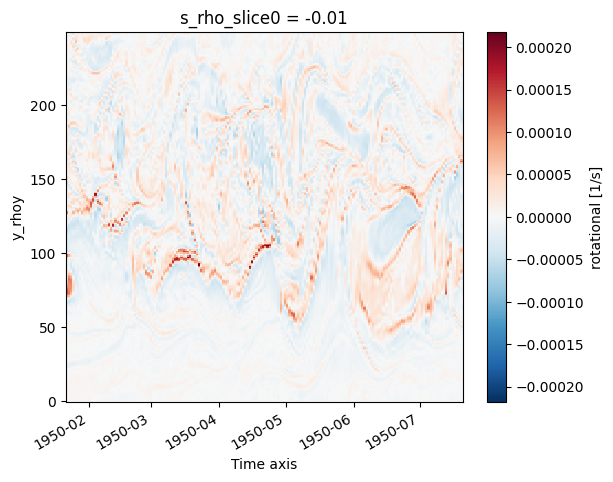

In [100]:
ds_v.T.plot()

Text(0.5, 0, 'f [cpkm]')

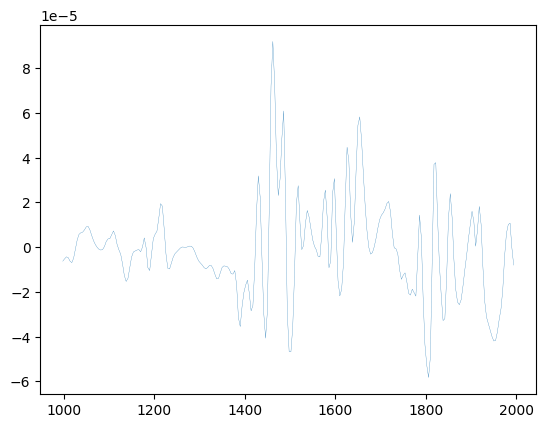

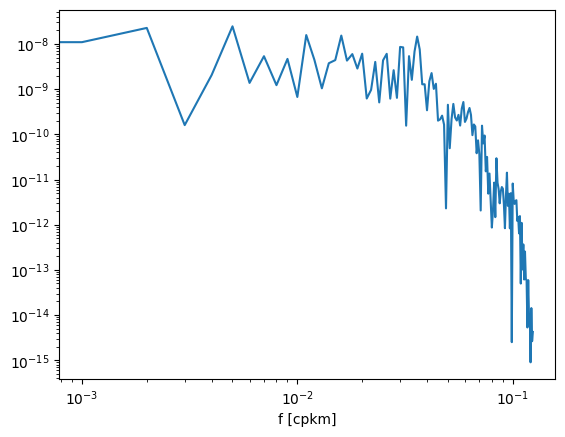

In [101]:
mypass = 20
y = ds_v.isel(time_counter=mypass).values
# X = ds['dist'].values*110 # km

#y = ds['alt_quality_flag'].isel(satpass=mypass).values#.interpolate_na('dist', method='pchip').values
#y = ds['ssha'].isel(satpass=mypass).values#.interpolate_na('dist', method='pchip').values

# X = ds_v['nav_lat_vy'].values*1e-3 # km
X = ds_v['nav_lat_rhoy'].values*1e-3 # km

dx = X[1]-X[0]
plt.plot(X,y, lw=0.2)
f, I = nsjax.periodogram(y, dx)

plt.figure()
plt.loglog(f, I)
plt.xlabel('f [cpkm]')

In [102]:
def itide_meso_gammaexp(x, xpr, params, gam_it=2 ):

    eta_m, l_m, gam_m, eta_it, d_it, l_it = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it, d_it, l_it, gam_it))

    return C

In [140]:
###
# Name of the parametric covariance function

# True values of the covariance model parameters

# eta_m = 0.3
# l_m = 70.
# gam_m = 1.25

eta_m = 1e-4
l_m = 50.
gam_m = 2


eta_it_D1 = 0.1
d_it_D1 = 500.
l_it_D1 = 150.


#gam_it = 1.5

covfunc=nsjax.gamma_exp_1d
covparams_guess = (eta_m, l_m, gam_m)

# covfunc = itide_meso_gammaexp
# covparams_guess = (eta_m, l_m, gam_m, eta_it_D1, d_it_D1, l_it_D1,  )



# Frequency bands for fitting
fmin = 8e-4 # 5e-4
fmax = 4e-2 #
# fmax = 2.5e-3 #


Text(0.5, 0, 'f [cpkm]')

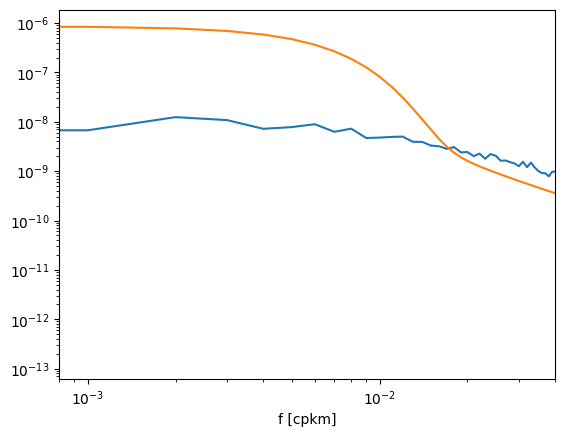

In [141]:
# Plot the periodogram of the time-series data and the parametric spectral profile
acf = covfunc(X, X[0], covparams_guess)


# f = ff
# I = onp.median(ss, axis=0)
# bochner function does the discrete ifft
f_S, S = nsjax.bochner(acf, delta=dx)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpkm]')

In [142]:
params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True,
                    #transformer=CustomTransformer,
                    f=f,
                    I=I)
print(72*'#')
print('Estimated: ',params)

step 0, loss: -1381.06005859375
[1.10517016e-04 5.52585182e+01 1.80967605e+00]
step 25, loss: -1438.635986328125
[5.0180348e-05 1.9080478e+02 1.0130301e+00]
step 50, loss: -1452.0943603515625
[3.4725414e-05 1.9242171e+02 5.9378010e-01]
step 75, loss: -1455.777099609375
[2.9194081e-05 1.5659872e+02 4.2570809e-01]
step 100, loss: -1456.5980224609375
[2.8073211e-05 1.3017433e+02 3.6012241e-01]
step 109, loss: -1456.697998046875
########################################################################
Estimated:  [2.7791857e-05 1.2335335e+02 3.4744212e-01]


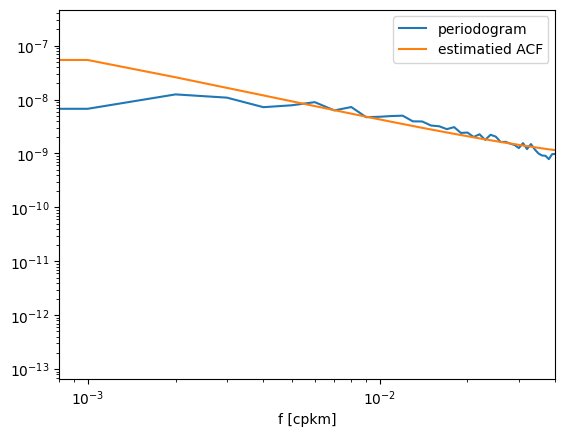

In [143]:
acf = covfunc(X, X[0], params)
_, S_est = nsjax.bochner(acf, delta=dx
                        )

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S_est)

plt.xlim(fmin, fmax)
plt.xlabel('f [cpkm]')
plt.legend(('periodogram','estimatied ACF'))

In [144]:
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)

integral_timescale(nsjax.gamma_exp_1d, params[0:3])

/tmp/ipykernel_2533672/3036615209.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  return 1./covparams[0]**2 * np.trapz(acf, t)


Array(158.26306, dtype=float32)

In [145]:
from tqdm import tqdm

In [146]:
nt = ds_v.time_counter.shape[0]

nparams = len(covparams_guess)
allparams = onp.zeros((nparams, nt))
Lall = onp.zeros((nt,))
plot = False

In [147]:
ss = onp.zeros((nt, f.shape[0]))

for ii in tqdm(range(nt)):
    y = ds_v.isel(time_counter=ii).values
    f, ss[ii,:] = nsjax.periodogram(y, dx)

100%|██████████| 180/180 [00:00<00:00, 375.35it/s]


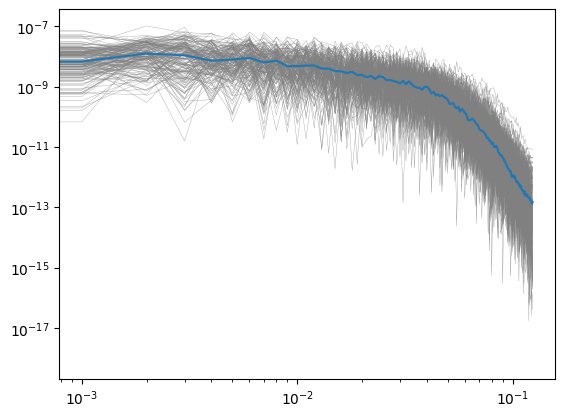

In [148]:
for ii in range(nt):
    plt.loglog(f, ss[ii,:],'0.5',lw=0.2)

# plt.loglog(ff, np.ss.mean(axis=0))
plt.loglog(f, np.median(ss, axis=0))
# plt.ylim(1e-1, 1e5)

In [149]:
I = np.median(ss, axis=0)
params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True,
                    #transformer=CustomTransformer,
                    f=f,
                    I=I)
print(72*'#')
print('Estimated: ',params)
L = integral_timescale(nsjax.gamma_exp_1d, params[0:3])

step 0, loss: -1381.06005859375
[1.10517016e-04 5.52585182e+01 1.80967605e+00]
step 25, loss: -1438.635986328125
[5.0180348e-05 1.9080478e+02 1.0130301e+00]
step 50, loss: -1452.0943603515625
[3.4725414e-05 1.9242171e+02 5.9378010e-01]
step 75, loss: -1455.777099609375
[2.9194081e-05 1.5659872e+02 4.2570809e-01]
step 100, loss: -1456.5980224609375
[2.8073211e-05 1.3017433e+02 3.6012241e-01]
step 109, loss: -1456.697998046875
########################################################################
Estimated:  [2.7791857e-05 1.2335335e+02 3.4744212e-01]


/tmp/ipykernel_2533672/3036615209.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  return 1./covparams[0]**2 * np.trapz(acf, t)


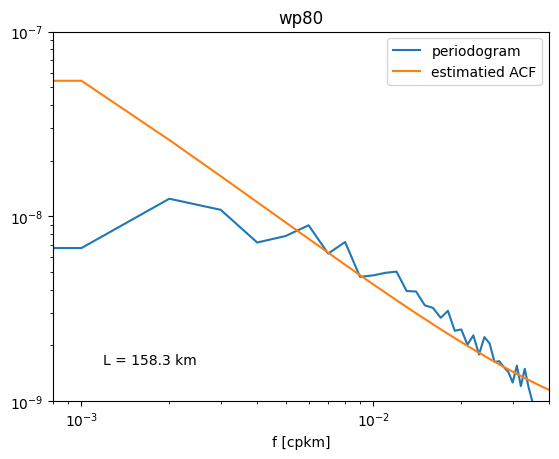

In [150]:
acf = covfunc(X, X[0], params)
_, S_est = nsjax.bochner(acf, delta=dx
                        )

#plt.figure()
fig,ax = plt.subplots(1)
plt.loglog(f, I)
plt.loglog(f_S,S_est)

plt.xlim(fmin, fmax)
plt.xlabel('f [cpkm]')
plt.legend(('periodogram','estimatied ACF'))
# plt.ylim(1e-3,50)
plt.ylim(1e-9,1e-7)

plt.title(scenario)
plt.text(0.1,0.1, f'L = {L:3.1f} km', transform=ax.transAxes)
plt.savefig(f'../FIGURES/wavenumber_spectra_{scenario}_vorticity.png', dpi=150)